# IOM rain season flood data

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [10]:
from thefuzz import process

from src.datasources import codab
from src.utils import blob
from src.constants import *

In [3]:
adm2 = codab.load_codab_from_blob(aoi_only=True, admin_level=2)

In [4]:
adm2

,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,DATE,VALIDON,VALIDTO,geometry
2,Abadam,NG008001,Borno,NG008,Nigeria,NG,2017-03-31,2019-04-17,None,"POLYGON ((13.11029 13.10963, 13.10815 13.11404..."
68,Askira/Uba,NG008002,Borno,NG008,Nigeria,NG,2017-03-31,2019-04-17,None,"POLYGON ((13.09852 10.44508, 13.09352 10.44667..."
82,Bade,NG036001,Yobe,NG036,Nigeria,NG,2017-03-31,2019-04-17,None,"MULTIPOLYGON (((11.18769 12.50815, 11.18360 12..."
90,Bama,NG008003,Borno,NG008,Nigeria,NG,2017-03-31,2019-04-17,None,"POLYGON ((13.99056 11.31251, 13.97581 11.30513..."
99,Bayo,NG008004,Borno,NG008,Nigeria,NG,2017-03-31,2019-04-17,None,"POLYGON ((11.65688 10.19681, 11.60128 10.20806..."
...,...,...,...,...,...,...,...,...,...,...
709,Toungo,NG002019,Adamawa,NG002,Nigeria,NG,2017-03-31,2019-04-17,None,"POLYGON ((12.21046 7.97042, 12.20300 7.96432, ..."
762,Yola North,NG002020,Adamawa,NG002,Nigeria,NG,2017-03-31,2019-04-17,None,"POLYGON ((12.40447 9.25767, 12.40226 9.26307, ..."
763,Yola South,NG002021,Adamawa,NG002,Nigeria,NG,2017-03-31,2019-04-17,None,"POLYGON ((12.43708 9.21300, 12.43732 9.21285, ..."
765,Yunusari,NG036016,Yobe,NG036,Nigeria,NG,2017-03-31,2019-04-17,None,"POLYGON ((12.13949 13.09935, 12.14254 13.09896..."


In [45]:
adm2["ADM2_EN_lower"] = adm2["ADM2_EN"].str.lower()

In [6]:
blob_name = (
    f"{blob.PROJECT_PREFIX}/raw/impact/iom/Rain season historical data.xlsx"
)

In [50]:
df = blob.load_excel_from_blob(blob_name)

In [51]:
df["LGA_lower"] = df["LGA"].str.lower()

In [52]:
"abadam" in adm2["ADM2_EN"].str.lower().to_list()

True

In [53]:
matches_dict = {
    "maiduguri m. c.": "maiduguri",
    "kala balge": "kala/balge",
    "tarmuwa": "tarmua",
}

In [55]:
for lga in df["LGA_lower"].unique():
    if not (lga in adm2["ADM2_EN_lower"].to_list() or lga in matches_dict):
        matches = process.extract(
            lga, adm2["ADM2_EN_lower"].to_list(), limit=5
        )
        print(lga)
        print(matches)
        break

In [56]:
df["ADM2_EN_lower"] = df["LGA"].str.lower().replace(matches_dict)

In [64]:
df_matched = df.merge(adm2[["ADM2_EN_lower", "ADM2_PCODE", "ADM2_EN"]])

In [65]:
df_matched[df_matched["ADM2_PCODE"].isnull()]

,S/N,AGENCY,STATE,LGA,Ward,Site ID,SITE NAME,Latitude,Longitude,Site Type,...,#IND affected,Death,Source of livelihood\nLost,Houses\nDestroyed,Food Stuff\nDestroyed,NFI Destroyed,LGA_lower,ADM2_EN_lower,ADM2_PCODE,ADM2_EN


In [69]:
df_matched.dtypes

S/N                                    int64
AGENCY                                object
STATE                                 object
LGA                                   object
Ward                                  object
Site ID                               object
SITE NAME                             object
Latitude                             float64
Longitude                            float64
Site Type                             object
TYPE OF INCIDENT                      object
INCIDENT DATE                 datetime64[ns]
#HH Affected                         float64
#IND affected                        float64
Death                                float64
Source of livelihood\nLost           float64
Houses\nDestroyed                    float64
Food Stuff\nDestroyed                float64
NFI Destroyed                        float64
LGA_lower                             object
ADM2_EN_lower                         object
ADM2_PCODE                            object
ADM2_EN   

In [70]:
df_matched.columns

Index(['S/N', 'AGENCY', 'STATE', 'LGA', 'Ward', 'Site ID', 'SITE NAME',
       'Latitude', 'Longitude', 'Site Type', 'TYPE OF INCIDENT',
       'INCIDENT DATE', '#HH Affected', '#IND affected', 'Death',
       'Source of livelihood\nLost', 'Houses\nDestroyed',
       'Food Stuff\nDestroyed', 'NFI Destroyed', 'LGA_lower', 'ADM2_EN_lower',
       'ADM2_PCODE', 'ADM2_EN'],
      dtype='object')

<Axes: >

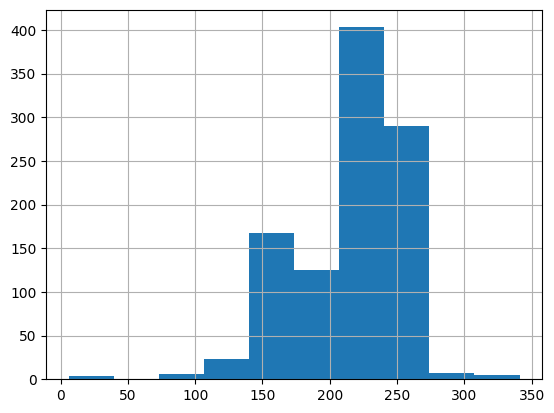

In [74]:
df_matched["INCIDENT DATE"].dt.dayofyear.hist()

In [77]:
df_matched["INCIDENT DATE"].min()

Timestamp('2021-06-11 00:00:00')

In [78]:
df_matched["INCIDENT DATE"].max()

Timestamp('2024-12-06 00:00:00')

In [80]:
blob_name = f"{blob.PROJECT_PREFIX}/processed/iom/rainseason_2021_2024.parquet"

In [81]:
blob.upload_parquet_to_blob(blob_name, df_matched)